# Capstone Project :Car Accident Severity
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Average number of car accidents in the U.S. every year is 6 million. 3 million people in the U.S. are injured every year in car accidents. Analysing the conditions that contribute to these accidents would lead to the prevention of significant loss of life and financial resources.

The project is aimed at **predicting the severity of a car accident** given the **location, weather, road and visibility conditions** in order to reduce the frequency of car collisions in a community based on dataset provided by **Seattle** PD. Consequently, this analysis would aid drivers to exercise more caution while driving or even choose an alternative route or time for their travel if possible. It could also potentially help the local government, the police department and car insurance providers to gain deeper insight into road accidents.

## Data <a name="data"></a>

The detailed dataset of all road collisions (since 2004 to present) can be found here. This data was provided by the Seattle Police Department and recorded by the Traffic Records Department. The dataset consists of 37 independent fields and 194673 records, which includes both numerical and categorical data. The dependent field or label for the data set is SEVERITYCODE, which describes the fatality of an accident. The values under this label are categorised into fatality (3), serious injury (2b), injury (2), prop damage (1) and unknown (0).

## Methodology <a name="methodology"></a>

In [124]:
#import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score, log_loss
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [126]:
#read the dataset and assign it to a dataframe

url ='https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(url)
df.head()

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [127]:
#examine the datatypes of each column
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [128]:
#replace null values in SPEEDING column with N
df['SPEEDING'].replace(np.nan,'N',inplace=True)
df.value_counts("SPEEDING")

SPEEDING
N    185340
Y      9333
dtype: int64

In [129]:
#create new dataframe with only the columns necessary for the analysis
df_acc = df[['SEVERITYCODE','ADDRTYPE','LOCATION', 'JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND','SPEEDING']]
df_acc.head()

,SEVERITYCODE,ADDRTYPE,LOCATION,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,2,Intersection,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Overcast,Wet,Daylight,N
1,1,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,N
2,1,Block,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Mid-Block (not related to intersection),Overcast,Dry,Daylight,N
3,1,Block,2ND AVE BETWEEN MARION ST AND MADISON ST,Mid-Block (not related to intersection),Clear,Dry,Daylight,N
4,2,Intersection,SWIFT AVE S AND SWIFT AV OFF RP,At Intersection (intersection related),Raining,Wet,Daylight,N


In [130]:
df_acc.dtypes

SEVERITYCODE     int64
ADDRTYPE        object
LOCATION        object
JUNCTIONTYPE    object
WEATHER         object
ROADCOND        object
LIGHTCOND       object
SPEEDING        object
dtype: object

In [131]:
df_acc.describe(include = "all")

,SEVERITYCODE,ADDRTYPE,LOCATION,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
count,194673.000000,192747,191996,188344,189592,189661,189503,194673
unique,NaN,3,24102,7,11,9,9,2
top,NaN,Block,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,Mid-Block (not related to intersection),Clear,Dry,Daylight,N
freq,NaN,126926,276,89800,111135,124510,116137,185340
mean,1.298901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.457778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
#examine the null values in the dataset

missing_data = df_acc.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
False    192747
True       1926
Name: ADDRTYPE, dtype: int64

LOCATION
False    191996
True       2677
Name: LOCATION, dtype: int64

JUNCTIONTYPE
False    188344
True       6329
Name: JUNCTIONTYPE, dtype: int64

WEATHER
False    189592
True       5081
Name: WEATHER, dtype: int64

ROADCOND
False    189661
True       5012
Name: ROADCOND, dtype: int64

LIGHTCOND
False    189503
True       5170
Name: LIGHTCOND, dtype: int64

SPEEDING
False    194673
Name: SPEEDING, dtype: int64



In [133]:
#replace the null values in the dataset with Unknown

df_acc['WEATHER'].replace(np.nan,'Unknown', inplace=True)
df_acc['ROADCOND'].replace(np.nan,'Unknown', inplace=True)
df_acc['LIGHTCOND'].replace(np.nan,'Unknown', inplace=True)
df_acc['JUNCTIONTYPE'].replace(np.nan,'Unknown', inplace=True)

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(



### UNDERSAMPLING

In [134]:
df_acc.value_counts("SEVERITYCODE")

SEVERITYCODE
1    136485
2     58188
dtype: int64

In [135]:
#balance label SEVERITYCODE by undersampling

target="SEVERITYCODE"
minority_class_len = len(df_acc[df_acc[target] ==2])
majority_class_indices = df_acc[df_acc[target] ==1].index
random_majority_indices = np.random.choice(majority_class_indices,minority_class_len, replace = False)
minority_class_indices = df_acc[df_acc[target] ==2].index

under_sample_indices = np.concatenate([minority_class_indices, random_majority_indices])
df_acc = df_acc.loc[under_sample_indices]
df_acc.value_counts("SEVERITYCODE")

SEVERITYCODE
2    58188
1    58188
dtype: int64


### EXPLORATORY DATA ANALYSIS

In [136]:
df_acc.describe(include="all")

,SEVERITYCODE,ADDRTYPE,LOCATION,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
count,116376.000000,115473,115136,116376,116376,116376,116376,116376
unique,NaN,3,19829,7,11,9,9,2
top,NaN,Block,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,Mid-Block (not related to intersection),Clear,Dry,Daylight,N
freq,NaN,71587,177,49590,68073,76182,71623,110371
mean,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.500002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
df.value_counts("JUNCTIONTYPE")

JUNCTIONTYPE
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
dtype: int64

In [257]:
#to find top car accident JUNCTIONTYPE and the corresponding severity code of accidents

df_group_ad= df_acc.groupby(['SEVERITYCODE','JUNCTIONTYPE']).size()
df_group_ad=pd.DataFrame(df_group_ad)
table_ad = pd.pivot_table(df_group_ad, values=0, index=['JUNCTIONTYPE'], columns=['SEVERITYCODE'], aggfunc=np.sum, fill_value=0)

table_ad['% of Total']=table_ad.sum(axis=1)
Total_ad=table_ad['% of Total'].sum(axis=0)
table_ad['% of Total']=round((table_ad['% of Total']/Total_ad)*100,2)
table_ad = table_ad.reindex(table_ad.sort_values(by='% of Total', ascending=False).index)
table_ad

SEVERITYCODE,1,2,% of Total
JUNCTIONTYPE,,,
Mid-Block (not related to intersection),30186,19404,42.61
At Intersection (intersection related),15036,27174,36.27
Mid-Block (but intersection related),6613,7297,11.95
Driveway Junction,3126,3234,5.47
Unknown,2543,402,2.53
At Intersection (but not related to intersection),637,623,1.08
Ramp Junction,47,54,0.09


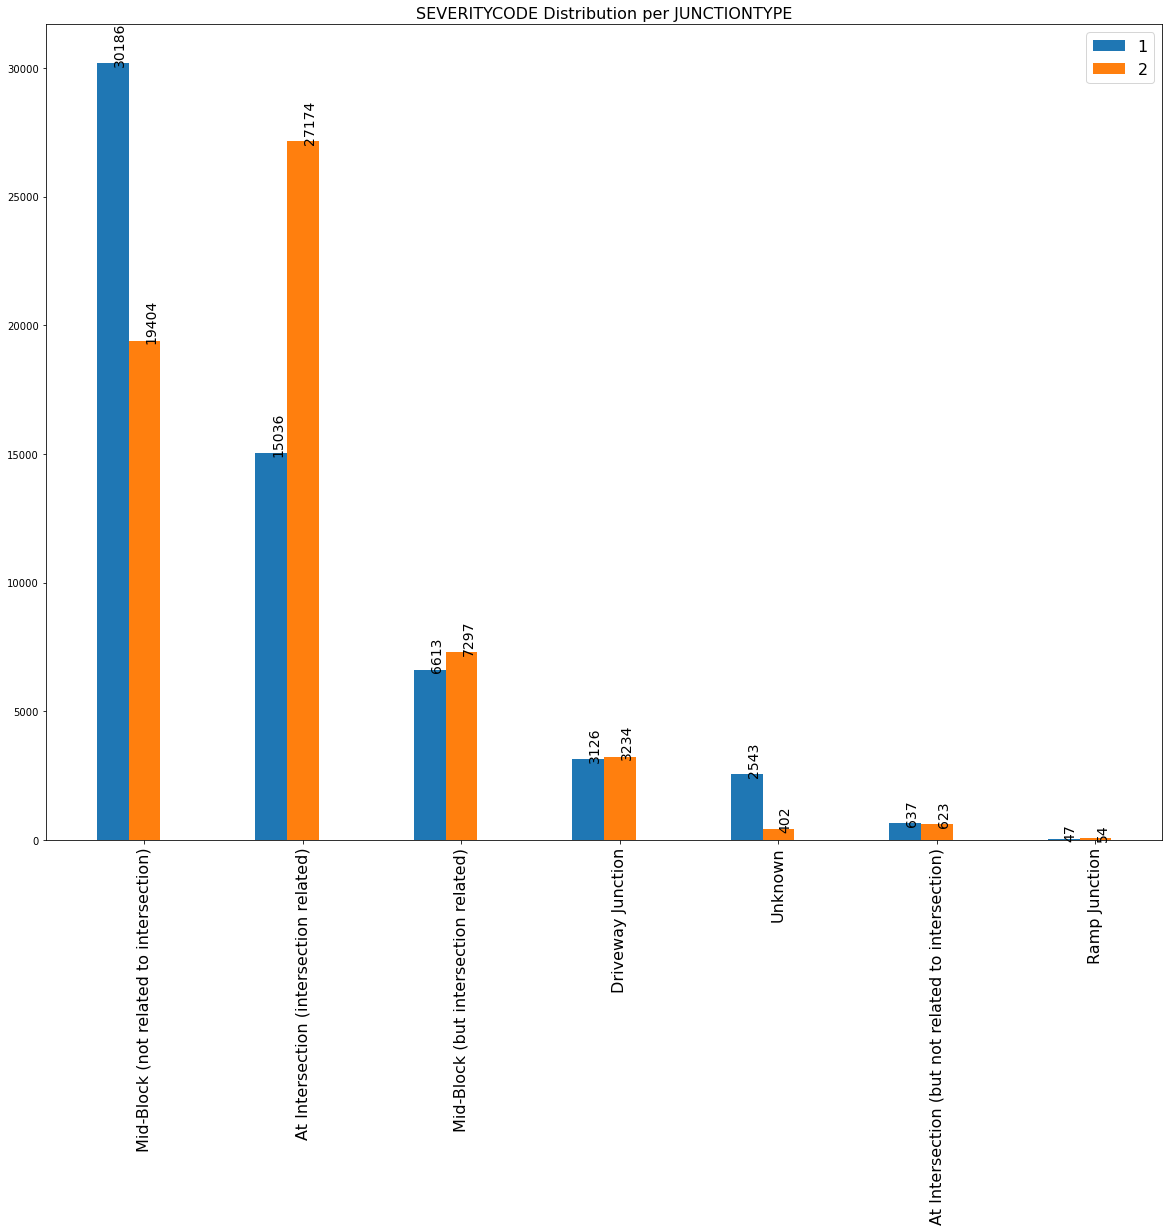

In [258]:
#plotting graph to compare frequency of different severity codes for different address types.
fig= plt.figure(figsize=(20,15))

barwidth=0.2

table_ad.reset_index(inplace=True)

bar1=table_ad[1]
bar2=table_ad[2]
r1=np.arange(len(bar1))
r2=[x+barwidth for x in r1]

plt.bar(r1,bar1,width=barwidth,label='1')
plt.bar(r2,bar2,width=barwidth,label='2')

#datalabels
for i in range(len(bar1)):
    plt.annotate(str(bar1[i]),xy=(r1[i],bar1[i]+0.25),fontsize=14,rotation='vertical')
for i in range(len(bar2)):
    plt.annotate(str(bar2[i]),xy=(r2[i],bar2[i]+0.25),fontsize=14,rotation='vertical')

#ad xticks
plt.title('SEVERITYCODE Distribution per JUNCTIONTYPE',fontsize=16)
plt.xticks([r+barwidth for r in range(len(bar1))],table_ad['JUNCTIONTYPE'],fontsize=16, rotation='vertical')
plt.ylim(bottom=0)
plt.legend(fontsize=16)
plt.show()

In [243]:
df.value_counts("LOCATION")

LOCATION
BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N    276
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB    271
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N          265
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST                    254
6TH AVE AND JAMES ST                                              252
                                                                 ... 
NE 70TH ST BETWEEN 51ST AVE NE AND 52ND AVE NE                      1
39TH AVE E AND E LEE ST                                             1
39TH AVE E AND HILLSIDE DR E                                        1
39TH AVE E AND MCGILVRA ER BLVD E                                   1
10TH AVE AND E ALDER ST                                             1
Length: 24102, dtype: int64

In [200]:
#to find top 10 car accident locations and the corresponding severity code of accidents

df_group_loc= df_acc.groupby(['SEVERITYCODE','LOCATION']).size()
df_group_loc=pd.DataFrame(df_group_loc)
table_loc = pd.pivot_table(df_group_loc, values=0, index=['LOCATION'], columns=['SEVERITYCODE'], aggfunc=np.sum, fill_value=0)

table_loc['Total']=table_loc.sum(axis=1)

table_loc = table_loc.reindex(table_loc.sort_values(by='Total', ascending=False).index)
table_loc.head(10)

SEVERITYCODE,1,2,Total
LOCATION,,,
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,57,120,177
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N,72,94,166
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB,80,86,166
6TH AVE AND JAMES ST,57,107,164
BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N,86,78,164
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,69,88,157
RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST,62,94,156
WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP,56,78,134
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP,69,63,132


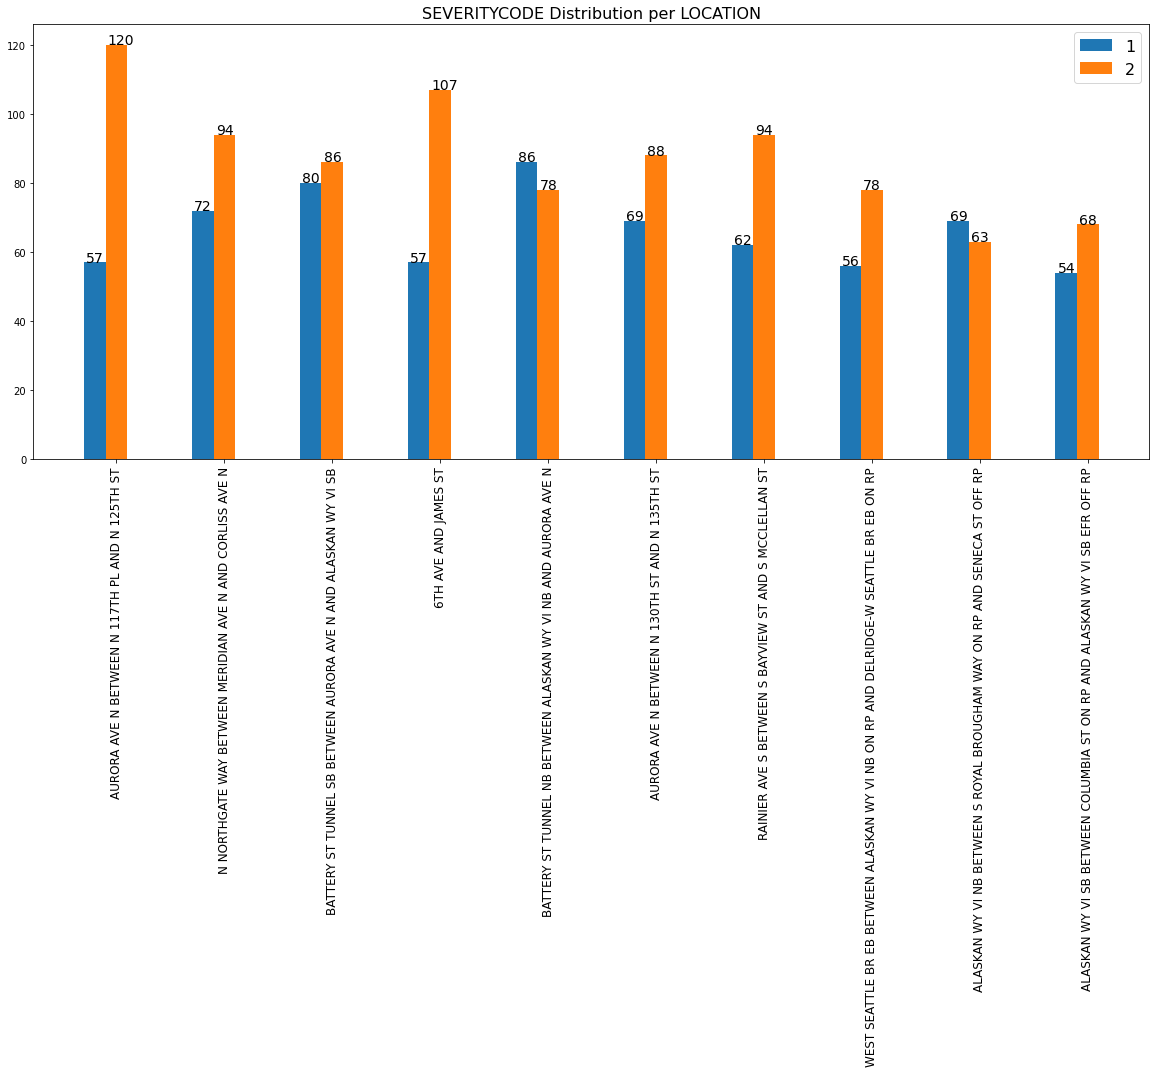

In [201]:
#plotting graph to compare frequency of different severity codes for different locations.
fig= plt.figure(figsize=(20,8))

barwidth=0.2

table_loc.reset_index(inplace=True)
table_loc=table_loc.head(10)
bar1=table_loc[1]
bar2=table_loc[2]
r1=np.arange(len(bar1))
r2=[x+barwidth for x in r1]

plt.bar(r1,bar1,width=barwidth,label='1')
plt.bar(r2,bar2,width=barwidth,label='2')

#datalabels
for i in range(len(bar1)):
    plt.annotate(str(bar1[i]),xy=(r1[i]-.08,bar1[i]+0.22),fontsize=14)
for i in range(len(bar2)):
    plt.annotate(str(bar2[i]),xy=(r2[i]-.08,bar2[i]+0.22),fontsize=14)

#ad xticks
plt.title('SEVERITYCODE Distribution per LOCATION',fontsize=16)
plt.xticks([r+barwidth for r in range(len(bar1))],table_loc['LOCATION'],fontsize=12,rotation='vertical')
plt.ylim(bottom=0)
plt.legend(fontsize=16)
plt.show()

In [143]:
df.value_counts("WEATHER")

WEATHER
Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
dtype: int64

In [239]:
#to find most common weather condition during car accidents and the corresponding severity code of accidents
df_group_w= df_acc.groupby(['SEVERITYCODE','WEATHER']).size()
df_group_w=pd.DataFrame(df_group_w)
table_w = pd.pivot_table(df_group_w, values=0, index=['WEATHER'], columns=['SEVERITYCODE'], aggfunc=np.sum, fill_value=0)

table_w['% of Total']=table_w.sum(axis=1)
Total_w=table_w['% of Total'].sum(axis=0)
table_w['% of Total']=round((table_w['% of Total']/Total_w)*100,2)
table_w = table_w.reindex(table_w.sort_values(by='% of Total', ascending=False).index)
table_w

SEVERITYCODE,1,2,% of Total
WEATHER,,,
Clear,32233,35840,58.49
Raining,9353,11176,17.64
Overcast,8006,8745,14.39
Unknown,7780,1900,8.32
Snowing,322,171,0.42
Other,270,116,0.33
Fog/Smog/Smoke,172,187,0.31
Sleet/Hail/Freezing Rain,32,28,0.05
Blowing Sand/Dirt,15,15,0.03


c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


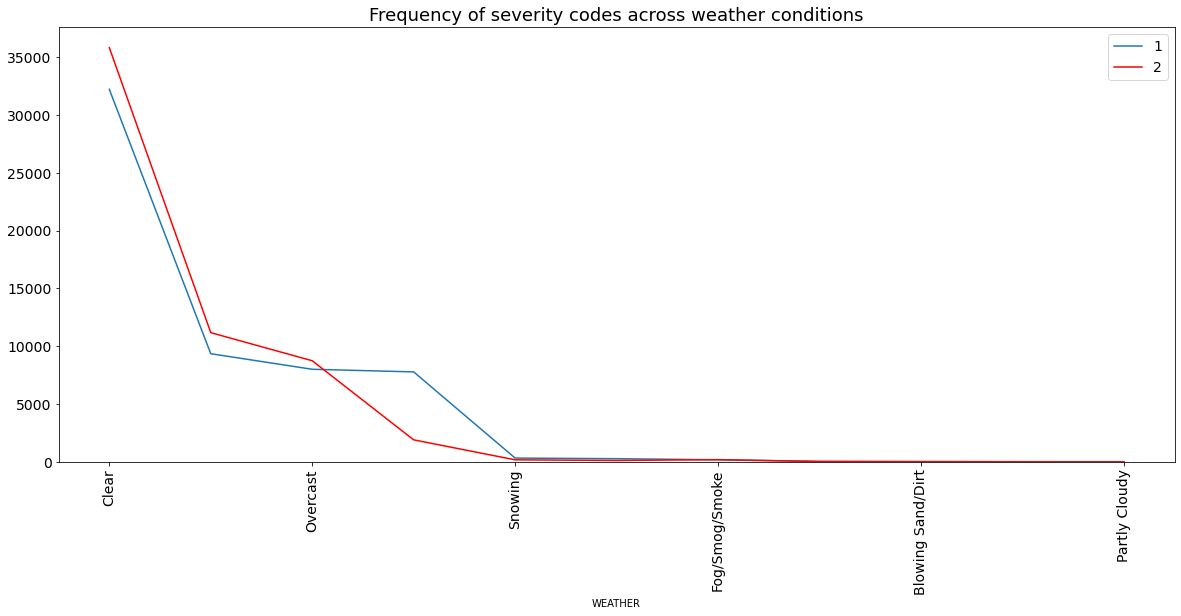

In [240]:

#plotting graph to compare frequency of different severity codes for different weather conditions.

fig= plt.figure(figsize=(20,8))
ax = plt.gca()
table_w.reset_index(inplace=True)
table_w.plot(kind='line',x='WEATHER',y=1,ax=ax)
table_w.plot(kind='line',x='WEATHER',y=2, color='red', ax=ax)
plt.ylim(bottom=0)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title('Frequency of severity codes across weather conditions',fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [263]:
df.value_counts("ROADCOND")

ROADCOND
Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
dtype: int64

In [264]:
]]#to find most common road condition during car accidents and the corresponding severity code of accidents
df_group_rc= df_acc.groupby(['SEVERITYCODE','ROADCOND']).size()
df_group_rc=pd.DataFrame(df_group_rc)
table_rc = pd.pivot_table(df_group_rc, values=0, index=['ROADCOND'], columns=['SEVERITYCODE'], aggfunc=np.sum, fill_value=0)

table_rc['% of Total']=table_rc.sum(axis=1)
Total_rc=table_rc['% of Total'].sum(axis=0)
table_rc['% of Total']=round((table_rc['% of Total']/Total_rc)*100,2)
table_rc = table_rc.reindex(table_rc.sort_values(by='% of Total', ascending=False).index)
table_rc.head()

SEVERITYCODE,1,2,% of Total
ROADCOND,,,
Dry,36118,40064,65.46
Wet,13463,15755,25.11
Unknown,7742,1809,8.21
Ice,414,273,0.59
Snow/Slush,340,167,0.44


c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


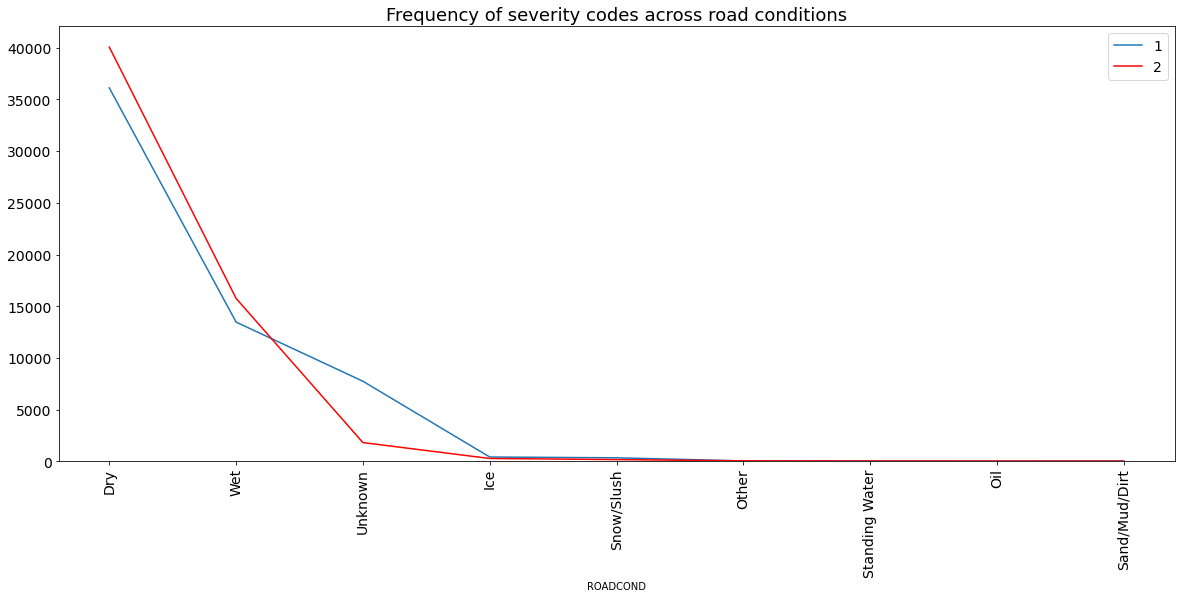

In [238]:
#plotting graph to compare frequency of different severity codes for different road conditions.

fig= plt.figure(figsize=(20,8))
ax = plt.gca()
table_rc.reset_index(inplace=True)
table_rc.plot(kind='line',x='ROADCOND',y=1,ax=ax)
table_rc.plot(kind='line',x='ROADCOND',y=2, color='red', ax=ax)
plt.ylim(bottom=0)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title('Frequency of severity codes across road conditions',fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [149]:
df.value_counts("LIGHTCOND")

LIGHTCOND
Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
dtype: int64

In [265]:
#to find most common light condition during car accidents and the corresponding severity code of accidents
df_group_lc= df_acc.groupby(['SEVERITYCODE','LIGHTCOND']).size()
df_group_lc=pd.DataFrame(df_group_lc)
table_lc = pd.pivot_table(df_group_lc, values=0, index=['LIGHTCOND'], columns=['SEVERITYCODE'], aggfunc=np.sum, fill_value=0)

table_lc['% of Total']=table_lc.sum(axis=1)
Total_lc=table_lc['% of Total'].sum(axis=0)
table_lc['% of Total']=round((table_lc['% of Total']/Total_lc)*100,2)
table_lc = table_lc.reindex(table_lc.sort_values(by='% of Total', ascending=False).index)
table_lc.head()

SEVERITYCODE,1,2,% of Total
LIGHTCOND,,,
Daylight,33079,38544,61.54
Dark - Street Lights On,14549,14475,24.94
Unknown,7270,1695,7.70
Dusk,1624,1944,3.07
Dawn,696,824,1.31


c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


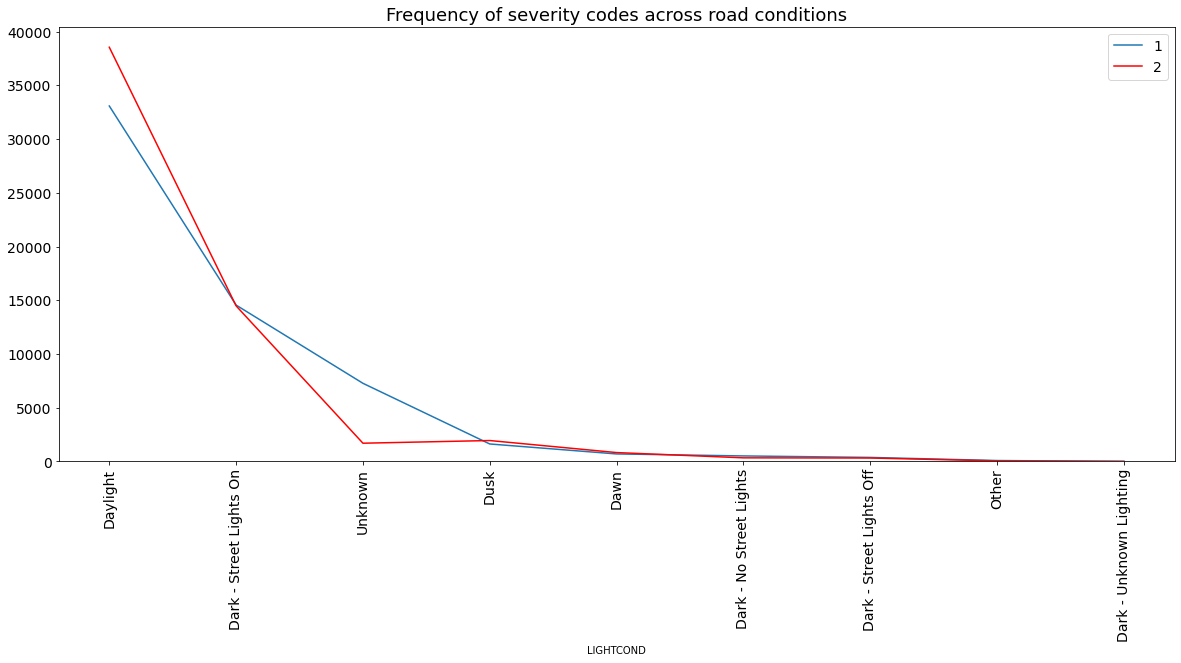

In [242]:

#plotting graph to compare frequency of different severity codes for different light conditions.

fig= plt.figure(figsize=(20,8))
ax = plt.gca()
table_lc.reset_index(inplace=True)
table_lc.plot(kind='line',x='LIGHTCOND',y=1,ax=ax)
table_lc.plot(kind='line',x='LIGHTCOND',y=2, color='red', ax=ax)
plt.ylim(bottom=0)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title('Frequency of severity codes across road conditions',fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [152]:
df.value_counts("SPEEDING")

SPEEDING
N    185340
Y      9333
dtype: int64

In [153]:
#to find most common light condition during car accidents and the corresponding severity code of accidents
df_group_s= df_acc.groupby(['SEVERITYCODE','SPEEDING']).size()
df_group_s=pd.DataFrame(df_group_s)
table_s = pd.pivot_table(df_group_s, values=0, index=['SPEEDING'], columns=['SEVERITYCODE'], aggfunc=np.sum, fill_value=0)

table_s['% of Total']=table_s.sum(axis=1)
Total_s=table_s['% of Total'].sum(axis=0)
table_s['% of Total']=round((table_s['% of Total']/Total_s)*100,2)
table_s = table_s.reindex(table_s.sort_values(by='% of Total', ascending=False).index)
table_s.head(5)

SEVERITYCODE,1,2,% of Total
SPEEDING,,,
N,55714,54657,94.84
Y,2474,3531,5.16




### MODEL EVALUATION

In [154]:
# label encoding

from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 
df_acc['WEATHER']=df_acc['WEATHER'].astype('str')
df_acc['WEATHER_cat']= label_encoder.fit_transform(df_acc['WEATHER']) 

df_acc['ADDRTYPE']=df_acc['ADDRTYPE'].astype('str')
df_acc['ADDRTYPE_cat']= label_encoder.fit_transform(df_acc['ADDRTYPE']) 

df_acc['JUNCTIONTYPE']=df_acc['JUNCTIONTYPE'].astype('str')
df_acc['JUNCTIONTYPE_cat']= label_encoder.fit_transform(df_acc['JUNCTIONTYPE']) 

df_acc['ROADCOND']=df_acc['ROADCOND'].astype('str')
df_acc['ROADCOND_cat']= label_encoder.fit_transform(df_acc['ROADCOND'])

df_acc['LIGHTCOND']=df_acc['LIGHTCOND'].astype('str')
df_acc['LIGHTCOND_cat']= label_encoder.fit_transform(df_acc['LIGHTCOND'])


df_acc['SPEEDING']=df_acc['SPEEDING'].astype('str')
df_acc['SPEEDING_cat']= label_encoder.fit_transform(df_acc['SPEEDING'])

df_acc.head()

,SEVERITYCODE,ADDRTYPE,LOCATION,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,WEATHER_cat,ADDRTYPE_cat,JUNCTIONTYPE_cat,ROADCOND_cat,LIGHTCOND_cat,SPEEDING_cat
0,2,Intersection,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related),Overcast,Wet,Daylight,N,4,2,1,8,5,0
4,2,Intersection,SWIFT AVE S AND SWIFT AV OFF RP,At Intersection (intersection related),Raining,Wet,Daylight,N,6,2,1,8,5,0
7,2,Intersection,BROADWAY AND E PIKE ST,At Intersection (intersection related),Clear,Dry,Daylight,N,1,2,1,0,5,0
9,2,Intersection,41ST AVE SW AND SW THISTLE ST,At Intersection (intersection related),Clear,Dry,Daylight,N,1,2,1,0,5,0
14,2,Block,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,Mid-Block (not related to intersection),Clear,Dry,Dark - Street Lights On,N,1,1,4,0,2,0


In [155]:
#initialization
x= df_acc[['WEATHER_cat','ROADCOND_cat','LIGHTCOND_cat','SPEEDING_cat','JUNCTIONTYPE_cat']]
y=df_acc['SEVERITYCODE']


In [156]:
#Normalizing the dataset
x=preprocessing.StandardScaler().fit(x).transform(x)
x

array([[ 0.30875114,  1.47118375,  0.32434045, -0.23325396, -1.14943182],
       [ 1.0026519 ,  1.47118375,  0.32434045, -0.23325396, -1.14943182],
       [-0.73210001, -0.71572314,  0.32434045, -0.23325396, -1.14943182],
       ...,
       [-0.73210001, -0.71572314,  0.32434045, -0.23325396, -1.14943182],
       [ 2.39045343,  1.19782039,  2.07035973, -0.23325396, -1.14943182],
       [-0.73210001, -0.71572314,  0.32434045, -0.23325396, -1.14943182]])

In [157]:
#Splitting the data as 70 % for training and 30 % for testing

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (81463, 5) (81463,)
Test set: (34913, 5) (34913,)



### MODELLING AND PREDICTIONS

#### K-Nearest Neighbors

In [158]:
# Training the Model
from sklearn.neighbors import KNeighborsClassifier
k=25

kneigh = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
k_y_pred = kneigh.predict(x_test)
k_y_pred[0:5]

array([2, 1, 1, 1, 1], dtype=int64)

In [159]:
#Model Evaluation
j1=jaccard_score(y_test,k_y_pred)
f1=f1_score(y_test,k_y_pred, average = 'macro')
print("Jaccard Score: ",j1)
print("F1 Score: ",f1)

Jaccard Score:  0.4510596594389318
F1 Score:  0.6148349280182468


#### Decision Tree

In [160]:
# Training the Model
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier (criterion = 'entropy', max_depth = 7)

dt.fit(x_train, y_train)
dt_y_pred = dt.predict(x_test)
dt_y_pred[0:5]

array([2, 1, 1, 1, 1], dtype=int64)

In [161]:
#Model Evaluation
j2=jaccard_score(y_test,dt_y_pred)
f2=f1_score(y_test,dt_y_pred, average = 'macro')
print("Jaccard Score: ",j2)
print("F1 Score: ",f2)

Jaccard Score:  0.43849031227672003
F1 Score:  0.6171862904671328


#### Linear Regression

In [162]:
# Training the Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(C = 6, solver = 'liblinear').fit(x_train, y_train)

lr_y_pred = lr.predict(x_test) 
lr_y_prob = lr.predict_proba(x_test)
lr_y_prob

array([[0.39458097, 0.60541903],
       [0.66094284, 0.33905716],
       [0.64601659, 0.35398341],
       ...,
       [0.53628072, 0.46371928],
       [0.58710319, 0.41289681],
       [0.51892818, 0.48107182]])

In [163]:
#Model Evaluation
j3=jaccard_score(y_test,lr_y_pred)
f3=f1_score(y_test,lr_y_pred, average = 'macro')
print("Jaccard Score: ",j3)
print("F1 Score: ",f3)
print("Log Loss: ",log_loss(y_test,lr_y_prob))

Jaccard Score:  0.45384
F1 Score:  0.6082536169528481
Log Loss:  0.6561502998049485


## Results and Discussion <a name="results"></a>

In [164]:
result = {'ML Model':['KNN','Decision Tree', 'Linear Regression'], 'Jaccard Score':[j1, j2, j3], 'F1 Score':[f1, f2, f3]}
result = pd.DataFrame.from_dict(result)
result

,ML Model,Jaccard Score,F1 Score
0,KNN,0.45106,0.614835
1,Decision Tree,0.43849,0.617186
2,Linear Regression,0.45384,0.608254


Evaluation metrics used to test the accuracy of our models were jaccard index and f-1 score. Choosing different k, max depth and hyperparameter C values helped to improve the accuracy of our models.

Through our exploratory data analysis, we have also observed that approximately 43% of all recorded accidents occur at the Blocks but the severity of the accident tends to be higher (SEVERITY CODE= 2 - Injury) at the intersection as compared to the blocks.

From this exercise, we can draw the result that our model can be trained to determine the severity of an accident to a certain extent using the given dataset and specific parameters such as WEATHER, ROADCOND, LIGHTCOND, SPEEDING and JUNCTIONTYPE.


## Conclusion <a name="conclusion"></a>

Based on evaluation of above models, it can be concluded that Linear Regression is the most ideal model for this case.